In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
class GridEnvironment:
    def __init__(self, size=20, obstacle_prob=0.2, start=(0, 0), goal=(19, 19)):
        self.size = size
        self.start = start
        self.goal = goal
        self.grid = np.zeros((size, size))
        for i in range(size):
            for j in range(size):
                if (i, j) != start and (i, j) != goal and random.random() < obstacle_prob:
                    self.grid[i][j] = -1
        self.actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        self.rewards = np.full((size, size), -0.1)
        self.rewards[goal] = 10

    def is_valid(self, pos):
        x, y = pos
        return 0 <= x < self.size and 0 <= y < self.size and self.grid[x][y] != -1

In [5]:
class ValueIterationAgent:
    def __init__(self, env, gamma=0.9, threshold=1e-3):
        self.env = env
        self.gamma = gamma
        self.threshold = threshold
        self.values = np.zeros((env.size, env.size))
        self.policy = np.zeros((env.size, env.size, len(env.actions)))

    def run(self):
        while True:
            delta = 0
            new_values = np.copy(self.values)
            for i in range(self.env.size):
                for j in range(self.env.size):
                    if (i, j) == self.env.goal or self.env.grid[i][j] == -1:
                        continue
                    q_values = []
                    for a, (dx, dy) in enumerate(self.env.actions):
                        new_pos = (i + dx, j + dy)
                        if not self.env.is_valid(new_pos):
                            new_pos = (i, j)
                        q_values.append(self.env.rewards[i][j] + self.gamma * self.values[new_pos])
                    new_values[i][j] = max(q_values)
                    delta = max(delta, abs(new_values[i][j] - self.values[i][j]))
            self.values = new_values
            if delta < self.threshold:
                break
        self.update_policy()

    def update_policy(self):
        for i in range(self.env.size):
            for j in range(self.env.size):
                if (i, j) == self.env.goal or self.env.grid[i][j] == -1:
                    continue
                best_action = np.argmax([
                    self.env.rewards[i][j] + self.gamma * self.values[min(max(i + dx, 0), self.env.size - 1), min(max(j + dy, 0), self.env.size - 1)]
                    for dx, dy in self.env.actions
                ])
                self.policy[i][j] = np.eye(len(self.env.actions))[best_action]

In [6]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, episodes=1000):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((env.size, env.size, len(env.actions)))
        self.episodes = episodes

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(len(self.env.actions)))
        else:
            return np.argmax(self.q_table[state])

    def train(self):
        for _ in range(self.episodes):
            state = self.env.start
            while state != self.env.goal:
                action = self.choose_action(state)
                dx, dy = self.env.actions[action]
                new_state = (state[0] + dx, state[1] + dy)
                if not self.env.is_valid(new_state):
                    new_state = state
                reward = self.env.rewards[state]
                self.q_table[state][action] = (1 - self.alpha) * self.q_table[state][action] + self.alpha * (reward + self.gamma * np.max(self.q_table[new_state]))
                state = new_state

In [7]:
def visualize_grid(env, agent_values=None, title="Environment"):
    plt.figure(figsize=(10, 10))
    grid = np.zeros((env.size, env.size, 3))
    for i in range(env.size):
        for j in range(env.size):
            if env.grid[i][j] == -1:
                grid[i, j] = [0, 0, 0]  # Black for obstacles
            elif (i, j) == env.start:
                grid[i, j] = [0, 1, 0]  # Green for start
            elif (i, j) == env.goal:
                grid[i, j] = [1, 0, 0]  # Red for goal
            else:
                value = agent_values[i, j] if agent_values is not None else 0
                grid[i, j] = [value, value, value]
    plt.imshow(grid)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [8]:
# Initialize environment and agents
env = GridEnvironment(size=20)
vi_agent = ValueIterationAgent(env)
q_agent = QLearningAgent(env)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


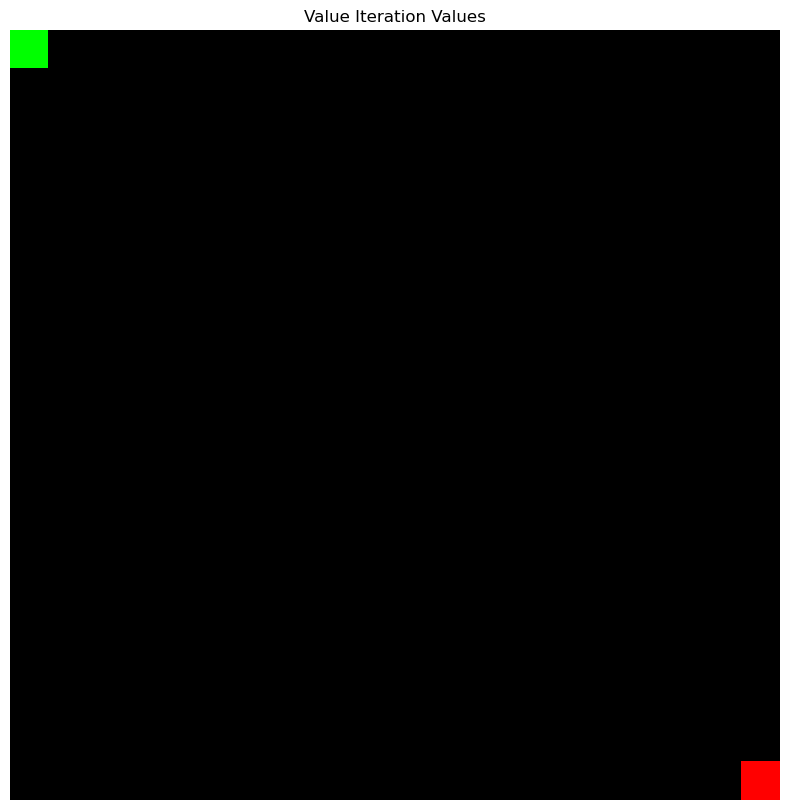

In [9]:
# Run Value Iteration
vi_agent.run()
visualize_grid(env, agent_values=vi_agent.values, title="Value Iteration Values")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


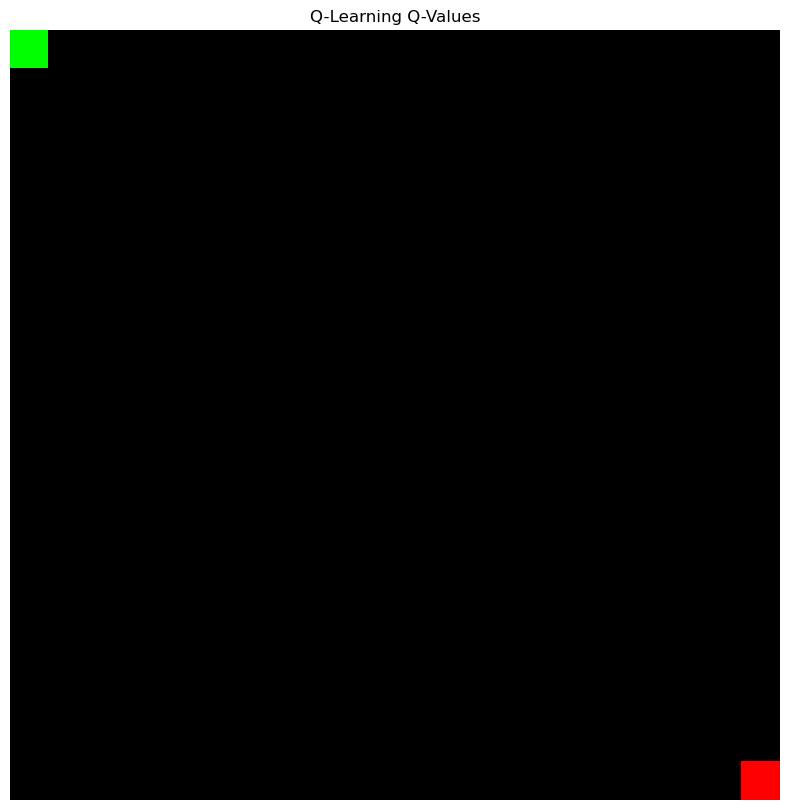

In [10]:
# Train Q-Learning Agent
q_agent.train()
visualize_grid(env, agent_values=np.max(q_agent.q_table, axis=2), title="Q-Learning Q-Values")

In [11]:
# Show both policies (Value Iteration & Q-Learning)
print("Value Iteration Optimal Policy:\n", vi_agent.policy)
print("Q-Learning Optimal Q-Table:\n", q_agent.q_table)

Value Iteration Optimal Policy:
 [[[0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 0. 1.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  ...
  [1. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 0.]]]
Q-Learning Optimal Q-Table:
 [[[-0.94981258 -0.94990695 -0.94998522 -0.95022628]
  [-0.94479592 -0.94612734 -0.9447499  -0.94495212]
  [-0.94031855 -0.94024637 -0.94024263 -0.94066608]
  ...
  [-0.85345887 -0.85269427 -0.85336947 -0.85289948]
  [-0.85138726 -0.85157838 -0.85151707 -0.85119529]
  [-0.85061831 -0.85077098 -0.85017009 -0.